In [275]:
%load_ext autoreload
%autoreload 2
import os
import random

import hydra
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataloader import ARMA
from dataloader import ElectricDevices
from hydra.experimental import compose
from hydra.experimental import initialize_config_dir
from interpretability import get_hist
from interpretability import global_interpretability
from interpretability import input_max_neuron
from interpretability import neuron_max_class
from interpretability import shapley_bottleneck_vs_class
from interpretability import shapley_bottleneck_vs_output
from interpretability import shapley_input_vs_bottleneck
from interpretability import shapley_input_vs_class
from interpretability import shapley_input_vs_output
from models.CAE import CAE
from train import Trainer
from utils import accuracy
from utils import data_bottleneck_exploration
from utils import data_input_exploration
from utils import get_predictions
from utils import observation_reconstruction
from utils import reconstruction

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

plt.rcParams.update({'font.size': 18})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

In [233]:
with initialize_config_dir(config_dir=os.path.abspath("configs")):
    cfg = compose(config_name="config")

dl = ElectricDevices()
#dl = ARMA(1)
data_train, data_valid, data_test = dl()

X_train, y_train = data_train[:, :, :-1], data_train[:, :, -1]
X_valid, y_valid = data_valid[:, :, :-1], data_valid[:, :, -1]
X_test, y_test = data_test[:, :, :-1], data_test[:, :, -1]

In [243]:
model = CAE(cfg.model)#, dilation=[2, 3, 5, 7])

ement: 9

EPOCH 2860 train loss: 0.6194547653198242, valid loss: 0.6267598748207093
epochs without improvement: 19

EPOCH 2870 train loss: 0.6196394443511963, valid loss: 0.6267912030220032
epochs without improvement: 1

EPOCH 2880 train loss: 0.6198337793350219, valid loss: 0.6265403628349304
epochs without improvement: 0

EPOCH 2890 train loss: 0.6194578766822815, valid loss: 0.6266857504844665
epochs without improvement: 10

EPOCH 2900 train loss: 0.6196406483650208, valid loss: 0.6266178965568543
epochs without improvement: 20

EPOCH 2910 train loss: 0.6196189284324646, valid loss: 0.6265211939811707
epochs without improvement: 5

EPOCH 2920 train loss: 0.6195661187171936, valid loss: 0.6265716195106507
epochs without improvement: 15

EPOCH 2930 train loss: 0.6195501565933228, valid loss: 0.6267245650291443
epochs without improvement: 25

EPOCH 2935 train loss: 0.619292151927948, valid loss: 0.6265613794326782
epochs without improvement: 30

Training Finished in 616.5363607406616s


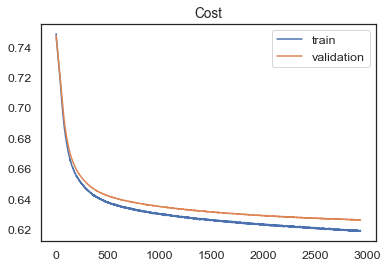

In [207]:
#trainer = Trainer(cfg.train)
#train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

In [235]:
# torch.save(model.state_dict(), "../weights/arma4.pth")
# model.load_state_dict(torch.load("../weights/mod.pth"))

<All keys matched successfully>

Predict testing data

In [245]:
 X_testp, y_testp = get_predictions(model, X_test)

# Evaluate

## Reconstruction

In [246]:
reconstruction(X_test, X_testp)

Distance Correlation avg and std: 0.731706300394008 0.26447387261251154
NRMSE: 0.19742132723331451



## Reconstruction of individual observations

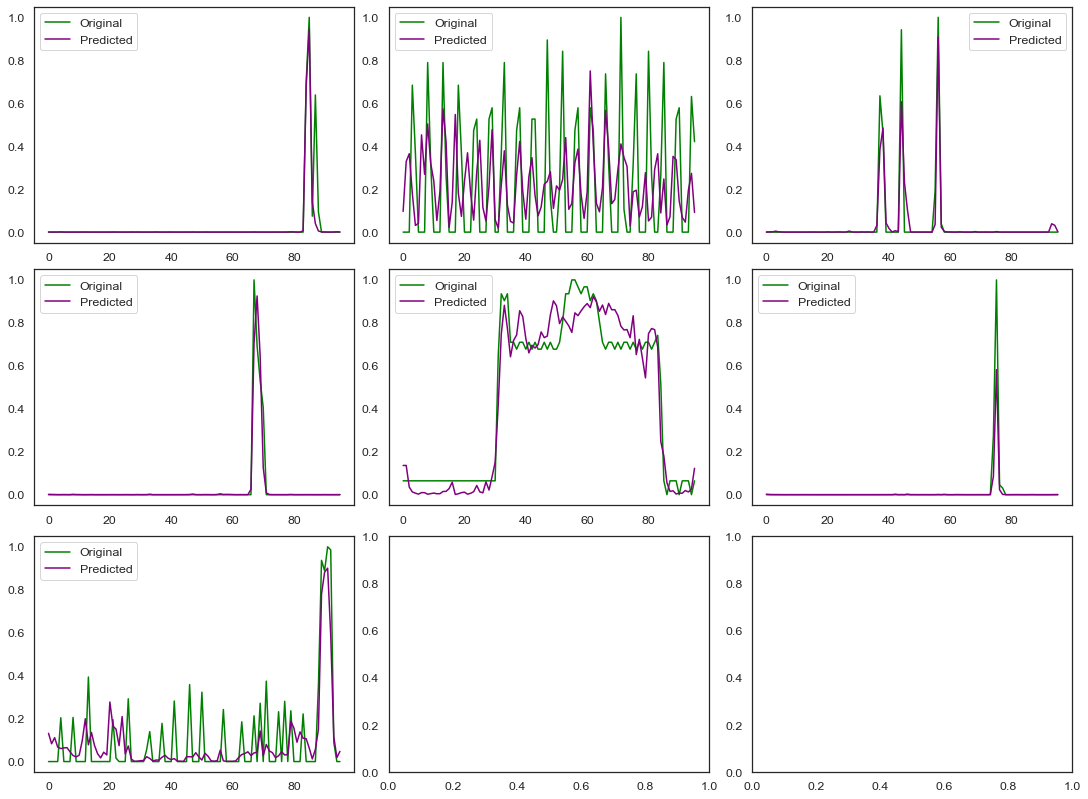

In [279]:
SELECTED = [np.random.choice([i for i, x in enumerate(y_test) if int(x) == j]) for j in range(1)]

SELECTED = [3279, 1156, 7419, 5046, 3323, 6485, 5497]

observation_reconstruction(SELECTED, X_test, X_testp, y_test, y_testp)

## Accuracy

Accuracy: 0.6188561794838542


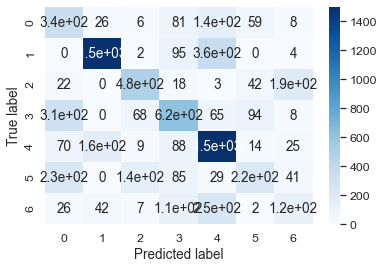

In [248]:
accuracy(y_test, y_testp)

# Data Exploration

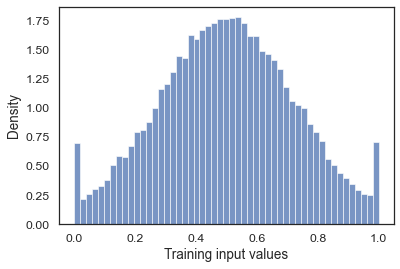

In [213]:
data_input_exploration(X_train)

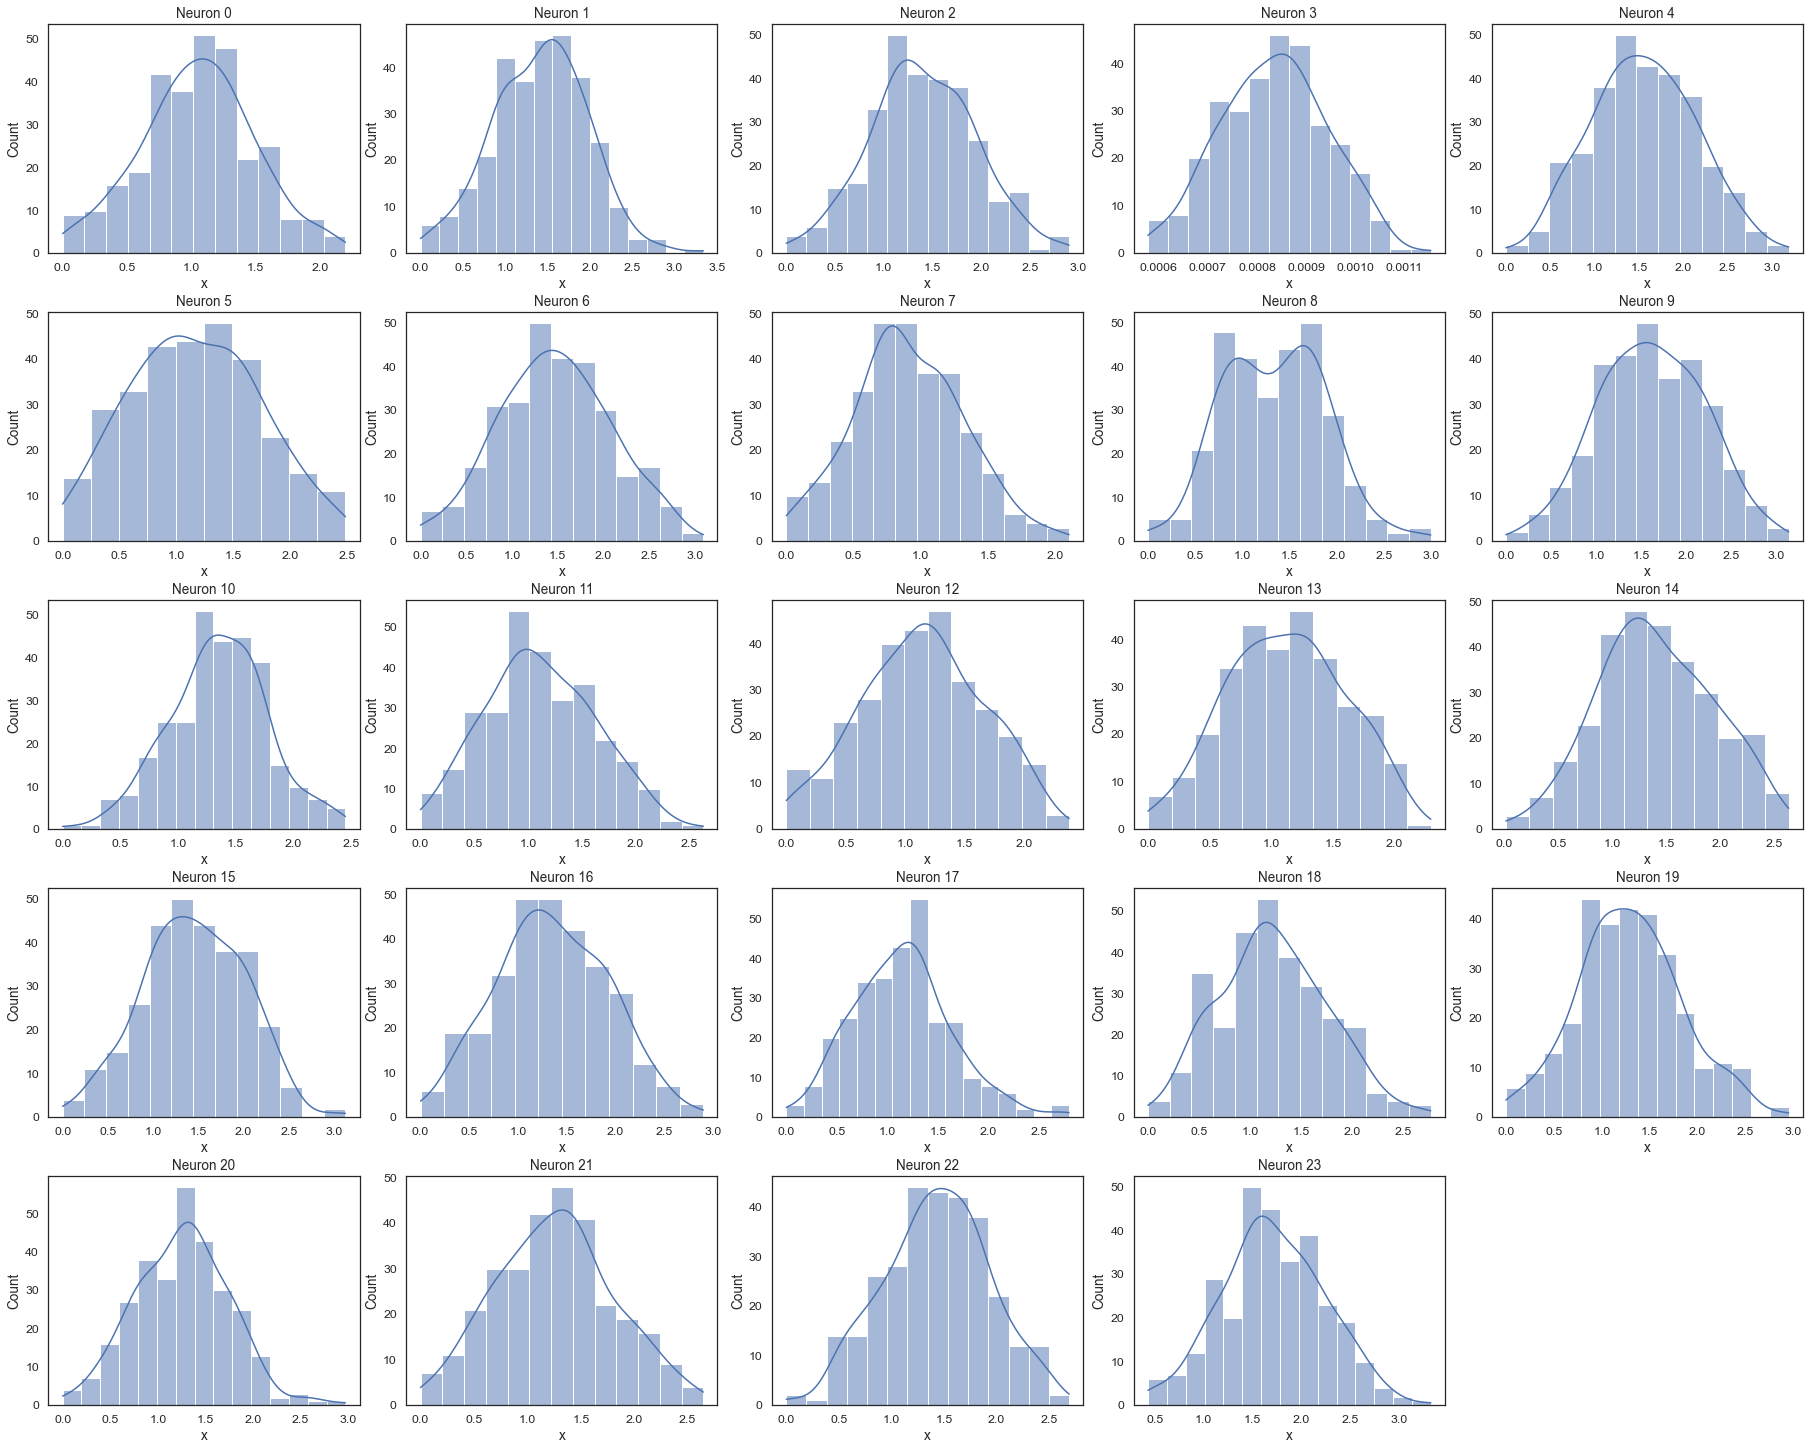

In [214]:
data_bottleneck_exploration(model, X_train)

# Interpretability

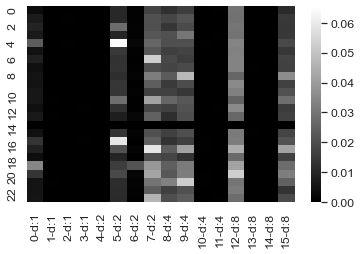

In [249]:
global_interpretability(model)

In [216]:
hist_input = [get_hist(X_train[:, 0, i]) for i in range(cfg.model.length)]
aux = model.encoder(X_train, False).detach().numpy()
hist_bn = [get_hist(aux[:, i]) for i in range(cfg.model.bottleneck_nn)]

In [217]:
shapley_input_vs_output(model, SELECTED, X_test, hist_input)

0 

KeyboardInterrupt: 

In [ ]:
shapley_bottleneck_vs_output(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_bottleneck(model, SELECTED, X_test, hist_input)

In [ ]:
shapley_bottleneck_vs_class(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_class(model, SELECTED, X_test, hist_input)

# Feature Visualization

In [ ]:
input_max_neuron(model)

In [ ]:
neuron_max_class(model)